# Hyperparameter Tuning: Random Forest

Hyperparameters is like the settings of an algorithm that can be adjusted to optimize performance. Hyperparameters must be set before training. In the case of a random forest, hyperparameters include the number of decision trees in the forest and the number of features considered by each tree when splitting a node.
Because hyperparameter tuning is based on experimental findings rather than theory, the easiest way to identify the ideal settings is to test many different combinations and evaluate the performance of each model. However, assessing each model only on the training set can lead to overfitting, one of the most fundamental difficulties in machine learning.

# Imports

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
pd.set_option('display.max_columns', None)
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import RandomOverSampler
from sklearn import tree
import gradio as gr

from pprint import pprint

# Load Data

In [2]:
tracks_clean = pd.read_csv('./data/tracks_clean.csv')

# Train/Test/Split

In [15]:
# setting up X and y
X = tracks_clean.drop(columns=['popularity', 'popularity_category', 'release_date'])
y = tracks_clean['popularity_category']

#test/train/split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    stratify=y
                                                   )

In [17]:
ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs_train = pd.DataFrame(Xs_train, columns = ss.get_feature_names_out())

Xs_test = pd.DataFrame(ss.transform(X_test), columns = ss.get_feature_names_out())

In [18]:
print('\ny_train Class Distribution:\n', y_train.value_counts(normalize=True))
print('\ny_test Class Distribution:\n', y_test.value_counts(normalize=True))


y_train Class Distribution:
 1    0.923916
0    0.076084
Name: popularity_category, dtype: float64

y_test Class Distribution:
 1    0.923915
0    0.076085
Name: popularity_category, dtype: float64


In [19]:
# Oversampling with RandomOverSampler
ros = RandomOverSampler()

Xs_train_over, y_train_over = ros.fit_resample(Xs_train, y_train)

In [20]:
print('\ny_train Class Distribution:\n', y_train_over.value_counts(normalize=True))
print('\ny_test Class Distribution:\n', y_test.value_counts(normalize=True))


y_train Class Distribution:
 1    0.5
0    0.5
Name: popularity_category, dtype: float64

y_test Class Distribution:
 1    0.923915
0    0.076085
Name: popularity_category, dtype: float64


In [21]:
rf = RandomForestClassifier(n_estimators=100)

print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


We will try adjusting the following set of hyperparameters:

    • n_estimators = number of trees in the foreset
    • max_features = max number of features considered for splitting a node
    • max_depth = max number of levels in each decision tree
    • min_samples_split = min number of data points placed in a node before the node is split
    • min_samples_leaf = min number of data points allowed in a leaf node
    • bootstrap = method for sampling data points (with or without replacement)

In [40]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 500, num = 10)]

# Number of features to consider at every split
max_features = ['auto']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 15, num = 5)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

#https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

In [41]:
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 11, 12, 13, 15, None],
 'max_features': ['auto'],
 'min_samples_leaf': [1, 2],
 'min_samples_split': [2, 5],
 'n_estimators': [200, 233, 266, 300, 333, 366, 400, 433, 466, 500]}


### Randomized Search with Cross Validation

In [42]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()

# Random search of parameters, using 5 fold cross validation
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(Xs_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/Users/josedelgadillo/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/josedelgadillo/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/josedelgadillo/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicit

/Users/josedelgadillo/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/josedelgadillo/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/josedelgadillo/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicit

/Users/josedelgadillo/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/josedelgadillo/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/josedelgadillo/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicit

/Users/josedelgadillo/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/josedelgadillo/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/josedelgadillo/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicit

/Users/josedelgadillo/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/josedelgadillo/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/josedelgadillo/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicit

/Users/josedelgadillo/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/josedelgadillo/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/josedelgadillo/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicit

/Users/josedelgadillo/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/josedelgadillo/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/josedelgadillo/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicit

/Users/josedelgadillo/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/josedelgadillo/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/josedelgadillo/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicit

/Users/josedelgadillo/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/josedelgadillo/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/josedelgadillo/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicit

/Users/josedelgadillo/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/josedelgadillo/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/josedelgadillo/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicit

/Users/josedelgadillo/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/josedelgadillo/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/josedelgadillo/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicit

/Users/josedelgadillo/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/josedelgadillo/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/josedelgadillo/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicit

/Users/josedelgadillo/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/josedelgadillo/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/josedelgadillo/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicit

/Users/josedelgadillo/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/josedelgadillo/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/josedelgadillo/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicit

[CV] END bootstrap=False, max_depth=15, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=333; total time= 9.0min
[CV] END bootstrap=False, max_depth=13, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=333; total time= 8.1min
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=433; total time= 7.7min
[CV] END bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=266; total time= 5.6min
[CV] END bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=266; total time= 5.4min
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=466; total time= 7.4min
[CV] END bootstrap=True, max_depth=11, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=433; total time= 5.1min
[CV] END bootstrap=True, max_depth=11, max_f

[CV] END bootstrap=True, max_depth=11, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time= 4.4min
[CV] END bootstrap=False, max_depth=15, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=333; total time= 9.2min
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=433; total time= 7.9min
[CV] END bootstrap=False, max_depth=13, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=12.1min
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=466; total time= 8.0min
[CV] END bootstrap=False, max_depth=13, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=366; total time= 6.9min
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=266; total time=11.4min
[CV] END bootstrap=True, max_depth=10, m

[CV] END bootstrap=True, max_depth=11, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time= 4.4min
[CV] END bootstrap=False, max_depth=15, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=333; total time= 9.2min
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=433; total time= 7.8min
[CV] END bootstrap=False, max_depth=13, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=12.1min
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=466; total time= 8.0min
[CV] END bootstrap=False, max_depth=13, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=366; total time= 6.8min
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=266; total time=11.6min
[CV] END bootstrap=True, max_depth=10, m

[CV] END bootstrap=True, max_depth=11, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time= 4.4min
[CV] END bootstrap=False, max_depth=13, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=333; total time= 8.0min
[CV] END bootstrap=False, max_depth=13, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=333; total time= 7.8min
[CV] END bootstrap=False, max_depth=13, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=12.1min
[CV] END bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=266; total time= 5.3min
[CV] END bootstrap=False, max_depth=13, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=366; total time= 7.3min
[CV] END bootstrap=True, max_depth=11, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=433; total time= 5.4min
[CV] END bootstrap=False, max_depth=None, ma

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 11, 12, 13, 15, None],
                                        'max_features': ['auto'],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [200, 233, 266, 300,
                                                         333, 366, 400, 433,
                                                         466, 500]},
                   random_state=42, verbose=2)

    The most important arguments in RandomizedSearchCV are n_iter, which controls the number of different combinations to try, and cv which is the number of folds to use for cross validation (we use 100 and 3). More iterations will cover a wider search space and more cv folds reduces the chances of overfitting.

In [43]:
rf_random.best_params_

{'n_estimators': 500,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': None,
 'bootstrap': False}

In [55]:
print('Train Accuracy: ' + str(rf_random.score(Xs_train, y_train)))
print('Test Accuracy: ' + str(rf_random.score(Xs_test, y_test)))

Train Accuracy: 0.9979793158313445
Test Accuracy: 0.9461987985080225


In [54]:
from sklearn.metrics import plot_confusion_matrix, accuracy_score, precision_score, f1_score

/Users/josedelgadillo/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


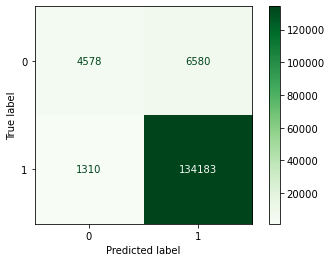

In [59]:
plot_confusion_matrix(rf_random, Xs_test, y_test, cmap='Greens', values_format='d', display_labels=['0', '1']);

# Hyperparameter tuning summary:

    After doing some hyperparameter tuning with the best the model that originally gave us the best score we only got a 0.02% increase on our accuracy test score and our accuracy training score stayed about the same. The amount of time did not really benifit the model at all. Either way we did have pretty good success over all with our accuracy scores which was the goal.